# Church & Temple Classification - Training Notebook

Here we will attempt a variety of techniques for classifying churches and temples from 11 different countries.  We assume that rotation has already been corrected by a separate process.

We have a few tricks up our sleeve to handle this kind of data.

1. __Augmentations__:  See `load_and_preprocess_data.ipynb`.  Every time an image is loaded from disk, it goes through a randomized set of augmentations, including random cropping, shearing, zooming, channel shift, horizontal flipping.
2. __Adjusted Sampling Rates__: Customize sampling rates from each country proportional to sqrt(N).  For instance, Russia has 11x as many images as Armenia, but will be sampled approximately 3.4x the rate of Armenia.
3. __Imbalanced Sample/Class Weights__: Increase the training weights of classes with few samples (Armenia, Australia)
4. __Transfer Learning from Pretrained Network__:  We will use Xception pre-trained network, which has excellent imagenet performance and relatively small (20M parameters).  When you remove the top, it emits a 10x10x2048 output for each image.  We might start with a global max/avg pooling, since we don't need the spatial information
5. __Add Intermediate Layer Outputs__:  In addition to using the 10x10x2048 output of Xception, we will grab the outputs from an intermediate layer in the network.  The reason for this is that high-frequency image components are likely to be valuable, since some countries' temples are very similiar, varying only by small deviations in shapes.  Also, it has additional value for picking up the "style" of the surroundings (much like is used in style transfer)
6. __Triple Loss Training__: This won't be the only method we try, but is likely to have good results due to the number of classes and limited images for some classes.  Thus, we can treat it a little bit like a face-recognition problem.
7. __Generators for Sampling from Disk__: We don't pull all the images into memory because it's a ton of data.  Instead we created a tf.data.Dataset from a generator that reads the images from disk on-the-fly.  *This is slow*, but likely necessary depending on the training environment.
8. __K-fold Cross-Validation__: Because there are so few images for some classes, it's just not possible to get reasonable performance metrics (such as Armenia with 11 images).  If we do k-fold cross-validation, we can at least get some idea on all 11 images.

------

In [3]:
import cv2
import os
import platform
import sys
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import numpy as np
import seaborn as sns
 
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
from tqdm import tqdm

print("OS Name: %s" % platform.system())
print(f'Using Python={sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Using Numpy={np.__version__}')
print(f'Using Matplotlib={matplotlib.__version__}')
print(f'Using Tensorflow={tf.__version__}')
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

OS Name: Linux
Using Python=3.7.2
Using Numpy=1.17.1
Using Matplotlib=3.1.2
Using Tensorflow=2.1.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [5]:
%load_ext autoreload
%autoreload 2

------

# Xception Network Architecture - Text Version
<img src="https://i.imgur.com/tA2qDIQ.jpg" width="800" height="800"/>

# Xception Network Architecture - Visualization
<img src="https://miro.medium.com/max/1451/1*NNsznNjzULwqvSER8k5eDg.png" width="900" height="600"/>



## First use our TrainDataInfo class to process and prepare all of our training data.
This indexes all training image paths, and calculates the adjusted sampling probabilities and training weights.  It also precomputes the different train-test splits that will be used for cross-validation

In [22]:
from load_and_preprocess_data import TrainDataInfo
from image_utilities import ImageUtilities
from training_utils import TrainingUtils

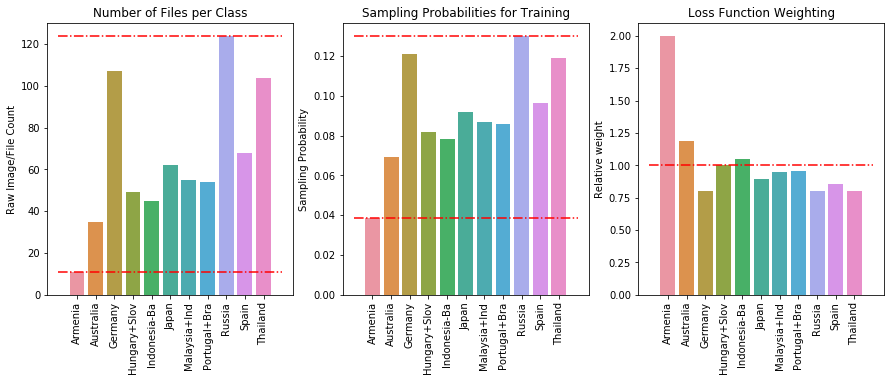

In [24]:
BATCH_SIZE=16
TRAIN_FOLDER='train_fixed_rotation'

# We set global parameters for our feature extractor -- currently Xception
INPUT_IMG_SIZE_2 = (299, 299)
INPUT_IMG_SIZE_3 = INPUT_IMG_SIZE_2 + (3,)

# This is used to abstract out the base, pre-trained network
def FEX_BASE_CREATE(trainable=False):
    print(f'Creating feature extractor base model, trainable={trainable}')
    model = Xception(weights='imagenet', include_top=False)
    model.trainable = trainable
    return model

all_train_info = TrainDataInfo(TRAIN_FOLDER, kfold_splits=5)
train_utils = TrainingUtils(all_train_info, INPUT_IMG_SIZE_3, BATCH_SIZE)
NUM_COUNTRIES = len(all_train_info.country_names)
all_train_info.display_rel_counts()

# Generate Baseline Performance
We will use the updated sampling rates, but create a network that is just a logistic regression on top of Xception outputs.  This is what we did for rotation detection (but in this case we'll build it into a Keras model).


In [25]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc

# Use this image and method to sanity check that created models take correct input, confirm output shape
# The Xception model has (None,None) for all layer sizes, making it difficult to 
zeros_img = np.zeros(shape=(1,) + INPUT_IMG_SIZE_3, dtype='float32')
print_output_shape = lambda model: print(f'Model output shape is {model(zeros_img).numpy().squeeze().shape}')

In [26]:
_ = ''' # This test here is burning RAM
fex_base = FEX_BASE_CREATE()
print(f'Returned base model has trainable={fex_base.trainable}')
print(f'Base feature extraction model has {len(fex_base.layers)} layers')
print_output_shape(fex_base)
fex_base = None
'''

In [27]:
# Max or Avg pooling is better?  I would expect Max, but the default is Avg, so use that
def generate_xception_logreg_model():
    x = inputs = L.Input(shape=INPUT_IMG_SIZE_3)
    x = FEX_BASE_CREATE()(x)
    #x = L.GlobalAvgPool2D()(x)
    x = L.Flatten()(x)
    # This is the logistic regression part
    x = predictions = L.Dense(NUM_COUNTRIES, activation='sigmoid')(x)
    return keras.models.Model(inputs=inputs, outputs=predictions)

simplest_model = generate_xception_logreg_model()
print_output_shape(simplest_model)
simplest_model.summary()

Creating feature extractor base model, trainable=False
Model output shape is (11,)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             multiple                  20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2252811   
Total params: 23,114,291
Trainable params: 2,252,811
Non-trainable params: 20,861,480
_________________________________________________________________


In [28]:
# Need to test the generator creation functions
k = 0
gen = train_utils.train_data_generator_memory(k, INPUT_IMG_SIZE_2, preproc_func=xcept_preproc)
train_ds = train_utils.generator_to_dataset(gen, INPUT_IMG_SIZE_3, NUM_COUNTRIES, BATCH_SIZE)
test_ds = train_utils.create_test_dataset(k, INPUT_IMG_SIZE_3, xcept_preproc, BATCH_SIZE)
for batch in train_ds.take(2):
    print(f'Train batch: {batch[0].shape}, {batch[1].shape}')
for batch in test_ds.take(2):
    print(f'Test batch:  {batch[0].shape}, {batch[1].shape}')

Filling image cache
Train batch: (16, 299, 299, 3), (16, 11)
Train batch: (16, 299, 299, 3), (16, 11)
Test batch:  (16, 299, 299, 3), (16, 11)
Test batch:  (16, 299, 299, 3), (16, 11)


In [ ]:
opt = keras.optimizers.RMSprop(1e-3)
#trained_model, y_true, y_pred, hist = train_utils.train_one_fold(generate_xception_logreg_model, kfold_index=0, epochs=1, optimizer=opt, model=trained_model)
trained_model, y_true, y_pred, hist = train_utils.train_one_fold(generate_xception_logreg_model, kfold_index=0, epochs=5, optimizer=opt)
print(hist)
        

Filling image cache
Creating new model for fold 0
Creating feature extractor base model, trainable=False
Epoch 1/5
36/36 [==============================] - 47s 1s/step - loss: 8.4424 - accuracy: 0.0933 - val_loss: 7.5865 - val_accuracy: 0.1233
Epoch 2/5
36/36 [==============================] - 44s 1s/step - loss: 6.6882 - accuracy: 0.1215 - val_loss: 7.5529 - val_accuracy: 0.1164
Epoch 3/5
36/36 [==============================] - 44s 1s/step - loss: 8.4837 - accuracy: 0.1673 - val_loss: 9.6687 - val_accuracy: 0.0753
Epoch 4/5
36/36 [==============================] - 44s 1s/step - loss: 8.4247 - accuracy: 0.2254 - val_loss: 10.3552 - val_accuracy: 0.0753
Epoch 5/5
36/36 [==============================] - 44s 1s/step - loss: 7.7148 - accuracy: 0.1180 - val_loss: 9.1515 - val_accuracy: 0.0479


In [ ]:
train_utils.print_classification_report(y_true, y_pred)

In [ ]:
model, y_true, y_pred, hist = train_eval_kfold_crossval(generate_xception_logreg_model, epochs=5)

In [ ]:
display_heatmaps(y_true, y_pred)

In [ ]:
train_utils.print_classification_report(y_true, y_pred)

------

In [ ]:
# The name of the intermediate layer we want is not consistent.  But the overall
# architecture is, so we will get it by index.  We want an early-middle layer
# to get some high-frequency info about the image
print('List of layers by index:')
for i,l in enumerate(fex_model.layers):
    print('  ', i, l.name)

In [ ]:
# Layer 45 is after the 5th out of 14 blocks
INTERMEDIATE_LAYERS = [25, 45]

# Just testing the model creation between inputs and an intermediate layer
for layer_idx in INTERMEDIATE_LAYERS:
    short_model = keras.models.Model(
        inputs=fex_model.layers[0].input,
        outputs=fex_model.layers[layer_idx].output)

    zeros_img = np.zeros(shape=(1,) + INPUT_IMG_SIZE_3, dtype='float32')
    print_output_shape(short_model)

In [ ]:

def generate_multi_out_xception_model():
    fex_base = FEX_BASE_CREATE()
    inp_layer = fex_base.layers[0].input
    inter_layers = [fex_base.layers[l].output for l in INTERMEDIATE_LAYERS]
    out_layer = fex_base.layers[-1].output
    
    outputs = [L.GlobalAveragePooling2D()(lout) for lout in (inter_layers + [out_layer])]
    combined_out = L.concatenate(outputs, axis=-1)
    
    return keras.models.Model(inputs=inp_layer, outputs=combined_out)
    
multi_out_base_model = generate_multi_out_xception_model()
multi_out_base_model.summary()

In [ ]:
print('Multi-output model:', multi_out_base_model(zeros_img).numpy().squeeze().shape)

In [ ]:
_ = '''
try:
    tf.keras.utils.plot_model(multi_out_base_model, show_shapes=True, dpi=64)
except Exception as e:
    print('Failed to generate visual model')
    raise
'''


## Save & Upload the Final Model

In [ ]:
import pickle
MODEL_FILENAME = 'church_temple_classify.clf'
with open(MODEL_FILENAME, 'wb') as fwrite:
    pickle.dump(chtemple_model, fwrite)
    
with open(MODEL_FILENAME, 'rb') as fread:
    chtemple_model = pickle.load(fread)

try:
    import boto3
    s3_client = boto3.client('s3')
    print(f'Uploading model to S3: {MODEL_FILENAME}')
    s3_client.upload_file(
        MODEL_FILENAME,
        'acr-toptal-codingproj',
        MODEL_FILENAME,
        ExtraArgs={'ACL': 'public-read'})
    print(f'Success!')
except Exception as e:
    print(f'Error uploading to S3, skipping: {str(e)}')

## Create a .py Wrapper
This includes the 

In [ ]:
%%writefile classification_wrapper.py
import cv2
import os
import pickle
import numpy as np
import tensorflow as tf
import subprocess
from image_utilities import ImageUtilities
from rotation_correction import RotationCorrection
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input

class ChurchTempleClassifier:
    def __init__(self, main_clf_file, rotate_clf_file):
        self.main_model_file = main_clf_file
        self.rotate_model_file = rotate_clf_file
        
        # This handles downloading the file if it doesn't exist yet.
        self.rotate_model = RotateCorrection(rotate_clf_file)
        
        # Need to reimplement downloading file if it doesn't exist, for main model
        if self.main_model_file is None or not os.path.exists(self.main_model_file):
            # Download with wget (to avoid the caller needing boto3 library)
            try:
                s3obj = 'https://acr-toptal-codingproj.s3.amazonaws.com/church_temple_classify.clf'
                print(f'Attempting to download: {s3obj}')
                subprocess.check_call(['wget', s3obj])
                print(f'Successful!')
            except Exception as e:
                raise 
                
            self.model_file = s3obj.split('/')[-1]
        else:
            print(f'Using already-downloaded model file: {self.model_file}')
                                    
    